In [1]:
import sympy as sy
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from scipy.integrate import quad
from progressbar import progressbar as pbar
from rlxutils import subplots
import pandas as pd
%matplotlib inline

from 

- https://stats.stackexchange.com/questions/199605/how-does-the-reparameterization-trick-for-vaes-work-and-why-is-it-important
- https://ermongroup.github.io/cs228-notes/

observe that we can rewrite the gradient of a function in the following manner:

$$
\begin{align}
\nabla_\theta q(x) &= \frac{q(x)}{q(x)}\nabla_\theta q(x)\\
&=q(x)\nabla_\theta \log q(x)
\end{align}
$$

This is nice, because if **$q(x)$ is a probability distribution** and we need to integrate $\int \nabla_\theta q(x)$, we can:

- rewrite it as $\int q(x) \nabla_\theta \log q(x)$
- use a MC estimate $\frac{1}{N}\sum_{x_i \sim q} \nabla_\theta \log q(x_i)$


**In particular**, if we are computing the **gradient of an expectation** of a function $f(x)$ with respect to distribution $q(x)$

$$
\begin{align}
\nabla_\theta \mathbb{E}_q[f(x)] &= \nabla_\theta \int q(x) f(x) dx &\;\;\;\;(1)\\
&= \int \nabla_\theta \big[q(x) f(x) \big] dx \\
&= \int  \big[ f(x)\nabla_\theta q(x) + q(x)\nabla_\theta f(x) \big] dx \\
&= \int  \big[ f(x)q(x)\nabla_\theta \log q(x) + q(x)\nabla_\theta f(x) \big] dx \\
&= \int  q(x) \big[ f(x)\nabla_\theta \log q(x) + \nabla_\theta f(x) \big] dx \\
&= \mathbb{E}_q  \big[ f(x)\nabla_\theta \log q(x) + \nabla_\theta f(x) \big] \\
&\approx \frac{1}{N}\sum_{x_i \sim q}  \big[ f(x_i)\nabla_\theta \log q(x_i) + \nabla_\theta f(x_i) \big]  &\;\;\;\;(2)\\
\end{align}
$$

eq (1) is the analytical expression for the expectation and eq (2) is its Montecarlo estimation

## a normal distribution, parametrized by $\mu=a$

- $a \in [-5, 5]$

$$x \sim \mathcal{N}(a, 1)$$

In [2]:
x, a, px = sy.symbols(r"x a p_x")

amin, amax = -5,5

sigma = sy.N(1)
# the PDF
#pdf  = sy.exp(-0.5*((x-a)/sigma_val)**2)/(sigma_val*sy.sqrt(2*sy.pi))
pdfx  = sy.exp(-0.5*((x-a)/sigma)**2)/(sigma*sy.sqrt(2*sy.pi))

_pdfx = sy.lambdify([x, a], pdfx, "numpy")

# a random value for parameter a
random_a = lambda N=1: np.random.random(N)*(amax-amin) + amin

# sampling from the distribution
samplex = lambda a_val, N: stats.norm(loc=a_val, scale=float(sigma.subs({a: a_val}))).rvs(N)

samplee = lambda N: stats.norm(loc=0, scale=1).rvs(N)

In [4]:
def get_xmin_xmax(a_val):
    _x = np.linspace(-1000,1000,1000000)
    _x = _x[_pdfx(_x, a=a_val)>1e-10]
    return _x.min(), _x.max()

## check and inspect the probability distribution

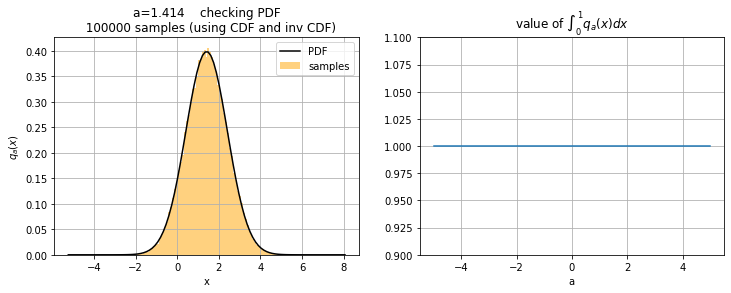

In [6]:
for ax, i in subplots(2, usizex=6, usizey=4):
    if i==0:
        a_val = random_a()[0]
        xmin, xmax = get_xmin_xmax(a_val)
        x_range = np.linspace(xmin,xmax,100)
        plt.plot(x_range, _pdfx(x_range, a_val), color="black", label="PDF")
        N = 100000
        xs = samplex(a_val, N)
        plt.hist(xs, bins=100, density=True, alpha=.5, color="orange", label="samples");
        plt.grid();
        plt.xlabel("x")
        plt.ylabel("$q_a(x)$")
        plt.title(f"a={a_val:.3f}    checking PDF\n  {N} samples (using CDF and inv CDF)");
        plt.legend();
    if i==1:
        a_range = np.linspace(amin, amax, 100)
        int01 = [quad(lambda x: _pdfx(x, a_val), *get_xmin_xmax(a_val))[0] for a_val in a_range]
        plt.plot(a_range, int01)
        plt.xlabel("a")
        plt.grid();
        plt.title("value of $\int_0^1 q_a(x) dx$")
        plt.ylim(.9,1.1)

## a function

In [8]:
f = sy.sin(x)
#f = sy.sin((a-np.pi/20)**2*x**2)
f = a*sy.sin(-a**2)*x
#f = sy.sin(x)*(x-1)**2
#f = sy.N(1)
f = sy.sin(a)**2 + (x-2)**2


## fix $a$ and comparing eq (1) and eq (2)

In [118]:
def compute_gradient_analytical(a_val):
    eint_fn = sy.lambdify(x, (pdfx*f).diff(a).subs({a: a_val}), "numpy")
    
    return quad(eint_fn, *get_xmin_xmax(a_val))[0]

def compute_gradient_mc(a_val, N=1000):
    qs = samplex(a_val, N)
    grad_fn = sy.lambdify(x, (f.diff(a) + sy.log(pdfx).diff(a)*f).subs({a: a_val}), "numpy")
    return grad_fn(qs).mean()

def compute_expectation_analytical(a_val):
    eint_fn = sy.lambdify(x, (pdfx*f).subs({a: a_val}), "numpy")
    return quad(eint_fn, *get_xmin_xmax(a_val))[0]

def compute_expectation_mc(a_val, N=1000):
    qs = samplex(a_val, N)
    grad_fn = sy.lambdify(x, f.subs({a: a_val}), "numpy")
    return grad_fn(qs).mean()

In [120]:
## using the reparametrization trick

def compute_egradient_mc(a_val, N=1000):
    es = samplee(N)
    
    e = sy.symbols("\epsilon")
    fdiff = f.subs({x: a+e}).diff(a).subs({a: a_val})
    return sy.lambdify(e, fdiff, "numpy")(es).mean()


def compute_eexpectation_mc(a_val, N=1000):
    es = samplee(N)    
    e = sy.symbols("\epsilon")
    eint = f.subs({x: a+e}).subs({a: a_val})    
    exp_fn = sy.lambdify(e, eint, "numpy")
    return exp_fn(es).mean()

In [36]:
compute_expectation_mc(2, N=1000000), compute_eexpectation_mc(2, N=1000000)

(1.8280966355339079, 1.8275915583355455)

### observe  the reparametrization trick

- we have more stability when we estimate the gradient of the expectation with the reparametrization trick
- same stability when estimating the expectation

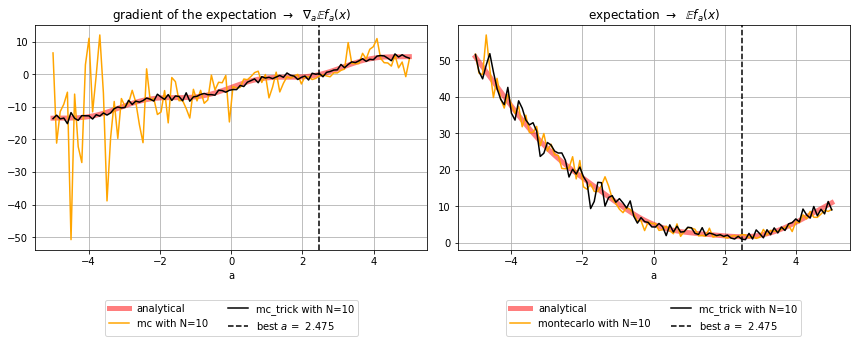

In [39]:
a_range = np.linspace(amin, amax, 100)
N = 10
ge_analitical = [compute_gradient_analytical(a_val) for a_val in a_range]
ge_mc  = [compute_gradient_mc(a_val, N=N) for a_val in a_range]
ege_mc = [compute_egradient_mc(a_val, N=N) for a_val in a_range]

e_analitical = [compute_expectation_analytical(a_val) for a_val in a_range]
e_mc = [compute_expectation_mc(a_val, N=N) for a_val in a_range]
ee_mc = [compute_eexpectation_mc(a_val, N=N) for a_val in a_range]

a_best = a_range[np.argmin(np.r_[ge_analitical]**2)]

for ax, i in subplots(2, usizex=6, usizey=5):
    if i==0:
        plt.plot(a_range, ge_analitical, label="analytical", lw=5, color="red", alpha=.5)
        plt.plot(a_range, ge_mc, label=f"mc with N={N}", color="orange")
        plt.plot(a_range, ege_mc, label=f"mc_trick with N={N}", color="black")
        plt.grid();
        plt.title(r"gradient of the expectation $\rightarrow$  $\nabla_a \mathbb{E} f_a(x)$")
        plt.xlabel("a")
        plt.axvline(a_best, color="black", label=f"best $a$ = {a_best: .3f}", ls="--")
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.legend(loc='upper center', ncol=2, bbox_to_anchor=(0.5, -0.2))        
    if i==1:
        plt.plot(a_range, e_analitical, label="analytical", lw=5, color="red", alpha=.5)
        plt.plot(a_range, e_mc, label=f"montecarlo with N={N}", color="orange")
        plt.plot(a_range, ee_mc, label=f"mc_trick with N={N}", color="black")
        plt.grid();
        plt.axvline(a_best, color="black", label=f"best $a$ = {a_best: .3f}", ls="--")
        plt.title(r"expectation $\rightarrow$  $\mathbb{E} f_a(x)$")
        plt.xlabel("a")
        plt.legend(loc='upper center', ncol=2, bbox_to_anchor=(0.5, -0.2))     
        
plt.tight_layout()



## let's do a small gradient ascent to get the best $a$

$$\text{arg min}_a \; \mathbb{E}_q[f(x)]$$

- we only use MC estimates for the gradient
- observe that when we use the reparametrization trick everything is more stable **specially with small $N$** (<3)


In [113]:


def optimize(N=1, use_reparametrization_trick=True, init_a_val=None):

    if init_a_val is None:
        a_val = np.random.random()*(amax-amin) + amin
    else:
        a_val = init_a_val
        
    learning_rate = .1
    lr_decay = 1e-2
    h = []
    
    print ("initial a", a_val)
    
    for step in range(101):

        if use_reparametrization_trick:
            grad = compute_egradient_mc(a_val, N)
        else:
            grad = compute_gradient_mc(a_val, N)
        expectation = compute_expectation_mc(a_val, N)

        if step%10==0:
            print (f"step {step:2d}: expectation for a={a_val:.3f} is {expectation:.5f}, grad is {grad:.5f}, lr is {learning_rate:.5f}")

        a_val -= learning_rate * grad
        learning_rate *= (1-lr_decay)
        h.append([step, a_val, expectation, grad, learning_rate])

    h = pd.DataFrame(h, columns=['step', 'a', 'expectation', 'grad', 'lr'])
    
    return h

In [114]:
init_a_val = np.random.random()*(amax-amin) + amin

In [115]:
h_trick = optimize(use_reparametrization_trick=True, N=2, init_a_val=init_a_val)

initial a -1.7770103976630702
step  0: expectation for a=-1.777 is 19.78645, grad is -5.96232, lr is 0.10000
step 10: expectation for a=1.304 is 1.13101, grad is -0.34098, lr is 0.09044
step 20: expectation for a=2.355 is 0.68706, grad is -0.34821, lr is 0.08179
step 30: expectation for a=2.620 is 0.47441, grad is 3.36597, lr is 0.07397
step 40: expectation for a=2.503 is 0.57136, grad is 1.38405, lr is 0.06690
step 50: expectation for a=2.566 is 1.13726, grad is -1.46419, lr is 0.06050
step 60: expectation for a=2.422 is 0.64909, grad is 0.54236, lr is 0.05472
step 70: expectation for a=2.572 is 0.31104, grad is -0.72392, lr is 0.04948
step 80: expectation for a=2.345 is 1.38757, grad is -1.26029, lr is 0.04475
step 90: expectation for a=2.696 is 2.23243, grad is -0.54363, lr is 0.04047
step 100: expectation for a=2.524 is 0.67570, grad is -0.37034, lr is 0.03660


In [116]:
h_notrick = optimize(use_reparametrization_trick=False, N=2, init_a_val=init_a_val)

initial a -1.7770103976630702
step  0: expectation for a=-1.777 is 21.99800, grad is 5.32794, lr is 0.10000
step 10: expectation for a=1.346 is 4.39296, grad is 3.20461, lr is 0.09044
step 20: expectation for a=0.570 is 1.21199, grad is 1.24163, lr is 0.08179
step 30: expectation for a=0.253 is 5.02888, grad is 1.26900, lr is 0.07397
step 40: expectation for a=1.803 is 3.12637, grad is -0.20225, lr is 0.06690
step 50: expectation for a=3.162 is 2.27290, grad is -0.19006, lr is 0.06050
step 60: expectation for a=2.520 is 0.51382, grad is -1.06490, lr is 0.05472
step 70: expectation for a=2.696 is 3.61985, grad is -0.88434, lr is 0.04948
step 80: expectation for a=2.489 is 0.52850, grad is -1.86870, lr is 0.04475
step 90: expectation for a=2.254 is 1.42146, grad is -2.49970, lr is 0.04047
step 100: expectation for a=2.638 is 0.34662, grad is -2.84563, lr is 0.03660


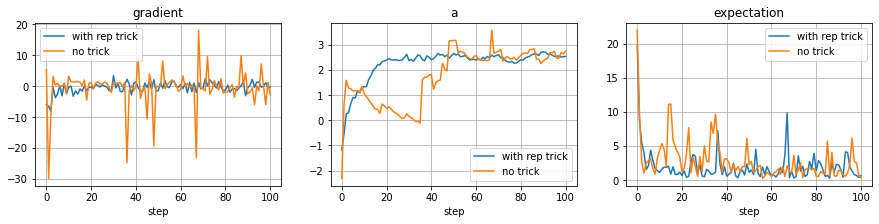

In [117]:
for ax,i in subplots(3, usizex=5):
    if i==0:
        plt.plot(h_trick.grad.values, label="with rep trick")
        plt.plot(h_notrick.grad.values, label="no trick")
        plt.grid(); plt.legend(); plt.xlabel("step"); plt.title("gradient");
    if i==1:
        plt.plot(h_trick.a.values, label="with rep trick")
        plt.plot(h_notrick.a.values, label="no trick")
        plt.grid(); plt.legend(); plt.xlabel("step"); plt.title("a");
    if i==2:
        plt.plot(h_trick.expectation.values, label="with rep trick")
        plt.plot(h_notrick.expectation.values, label="no trick")
        plt.grid(); plt.legend(); plt.xlabel("step"); plt.title("expectation");